# Verifast Product Analyst Assignment 

### Prakhar Singh
### Date of submission: 27/01/2025

In [2]:
# Cleaning of data - creating csv file 

import pandas as pd
import json
from pandas import json_normalize
from urllib.parse import urlparse, parse_qs

# Load data
file_path = r'/Users/prakharsingh/Downloads/assignment_raw_data.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Step 1: Normalize data
df = json_normalize(data)

# Step 2: Extract Product Information
def get_product_title(row):
    # Check for product variant title
    variant_title = row.get('properties.payload.data.productVariant.product.title')
    if pd.notna(variant_title) and isinstance(variant_title, str):
        return variant_title
    
    # Check for checkout products
    checkout_products = row.get('properties.payload.data.checkout.product')
    if checkout_products:
        if isinstance(checkout_products, list):
            return ', '.join([p.get('title', '') for p in checkout_products if p])
        elif isinstance(checkout_products, dict):
            return checkout_products.get('title', '')
    
    # Check for product title in cart events
    cart_product_title = row.get('properties.payload.data.product.title')
    if pd.notna(cart_product_title) and isinstance(cart_product_title, str):
        return cart_product_title
    
    return None

# Modify to use vectorized approach
def safe_extract_utm_params(href):
    if pd.isna(href) or not isinstance(href, str):
        return pd.Series([None, None, None, None, None], 
                          index=['utm_source', 'utm_medium', 'utm_campaign', 'utm_content', 'utm_id'])
    
    parsed_url = urlparse(href)
    params = parse_qs(parsed_url.query)
    
    return pd.Series({
        'utm_source': params.get('utm_source', [None])[0],
        'utm_medium': params.get('utm_medium', [None])[0],
        'utm_campaign': params.get('utm_campaign', [None])[0],
        'utm_content': params.get('utm_content', [None])[0],
        'utm_id': params.get('utm_id', [None])[0]
    })

# Apply product title extraction
df['product_title'] = df.apply(get_product_title, axis=1)

# Extract UTM parameters
utm_df = df['properties.payload.context.href'].apply(safe_extract_utm_params)
df = pd.concat([df, utm_df], axis=1)

# Clean Time
df['time'] = pd.to_datetime(df['properties.time'], unit='s', errors='coerce')

# Clean Customer ID
df['customer_id'] = df['properties.customer_id'].replace('', 'guest').fillna('guest')

# Finalize Columns
final_cols = [
    'event', 
    'time', 
    'customer_id',
    'properties.payload.context.href',
    'product_title',
    'utm_source',
    'utm_medium', 
    'utm_campaign',
    'utm_content',
    'utm_id'
]

final_df = df[final_cols].rename(columns={
    'properties.payload.context.href': 'referrer_url'
})

# Save
final_df.to_csv('cleaned_ecommerce_data.csv', index=False)

Chatbot Engagement Analysis:
Total Users: 7308.00
Chatbot Users: 221.00
Chatbot Engagement %: 3.02


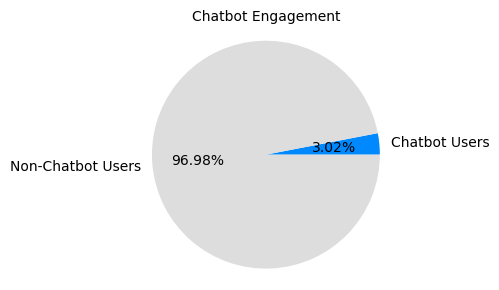

--------------------------------------------
Key Metrics:
* Total users who started checkout: 453
* Users who abandoned checkout: 261
* Abandonment Rate: 57.62%


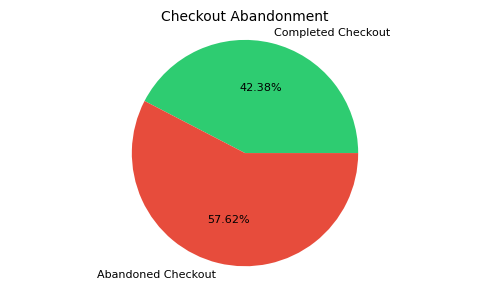

Checkout Abandonment and Chatbot Interaction Analysis:
* Total users who started checkout: 453
* Users who abandoned checkout: 261
* Abandoned users who interacted with chatbot: 37
* Percentage of abandoned users who used chatbot: 14.18%

Events for Abandoned Chatbot Users:
event
product_viewed           193
message_received         118
product_added_to_cart     97
checkout_started          64
chatbot:open              55
message_sent              29
search_submitted           6
Name: count, dtype: int64


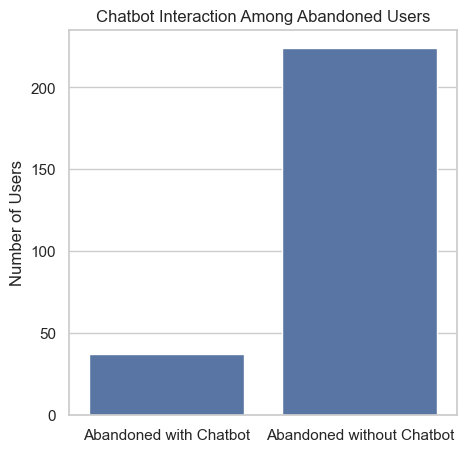

----------------------------------------------------
Chatbot Engagement:
Users opened chatbot: 221
Chatbot users converted: 34 (15.4%)
Chatbot users abandoned cart: 66

Top Performing UTM Channels:
utm_source utm_medium  conversion_rate  total_checkouts
    contlo   whatsapp         1.000000               17
    contlo      email         0.500000                5
    contlo   whatsapp         0.111111                3

Conversion Rates:
Chatbot users: 15.4%
Non-chatbot users: 2.5%

Retention Rates:
Chatbot users: 0.0%
Non-chatbot users: 1.1%


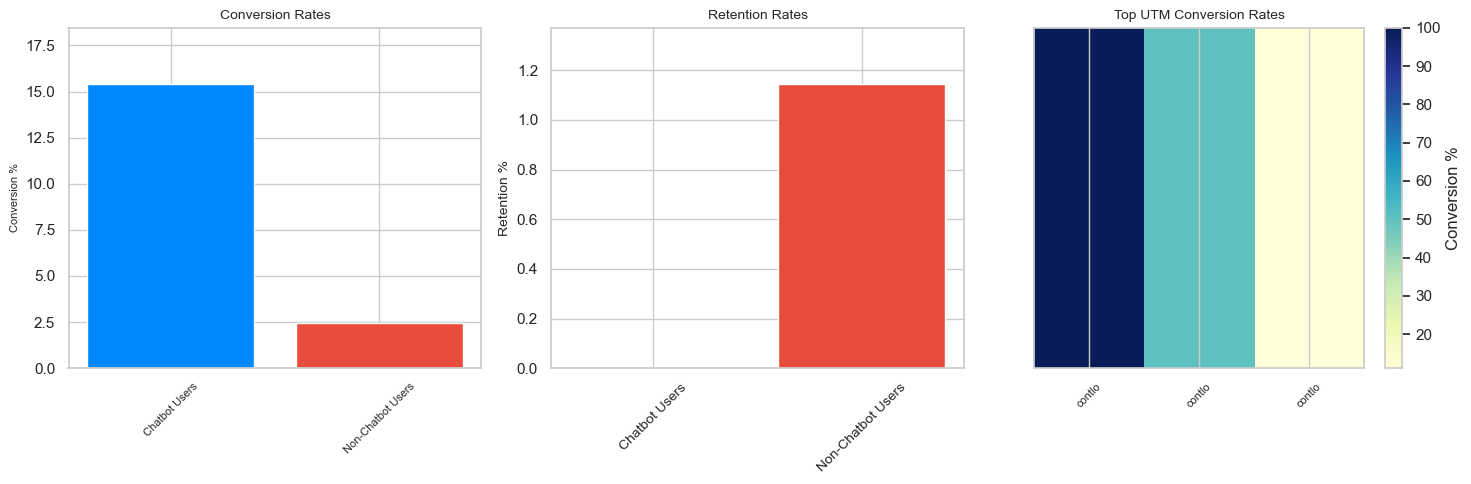

In [3]:
#Analysis Question 1 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('cleaned_ecommerce_data.csv')
df['time'] = pd.to_datetime(df['time'])

# Calculate total users
total_users = df['customer_id'].nunique()

# Calculate chatbot users
chatbot_events = df[df['event'] == 'chatbot:open']
chatbot_users = chatbot_events['customer_id'].nunique()
non_chatbot_users = total_users - chatbot_users

# Print specific output
print("Chatbot Engagement Analysis:")
print(f"Total Users: {total_users:.2f}")
print(f"Chatbot Users: {chatbot_users:.2f}")
print(f"Chatbot Engagement %: {(chatbot_users / total_users) * 100:.2f}")

# Create pie chart
plt.figure(figsize=(5, 3))
plt.pie(
   [chatbot_users, non_chatbot_users], 
   labels=['Chatbot Users', 'Non-Chatbot Users'],
   autopct='%1.2f%%',
   colors=['#0088FE', '#DDDDDD'],
   textprops={'fontsize': 10}  
)
plt.title('Chatbot Engagement', fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show() 

print('--------------------------------------------')

# Checkout Abandonment Analysis
started_checkout = df[df['event'] == 'checkout_started']['customer_id'].unique()
completed_checkout = df[df['event'] == 'checkout_completed']['customer_id'].unique()
total_checkout_starters = len(started_checkout)
abandoned_checkout_users = set(started_checkout) - set(completed_checkout)
num_abandoned = len(abandoned_checkout_users)
abandonment_rate = num_abandoned / total_checkout_starters * 100

# Print metrics
print(f"Key Metrics:")
print(f"* Total users who started checkout: {total_checkout_starters}")
print(f"* Users who abandoned checkout: {num_abandoned}")
print(f"* Abandonment Rate: {abandonment_rate:.2f}%")

# Create pie chart for checkout abandonment
plt.figure(figsize=(5, 3))
plt.pie(
   [total_checkout_starters - num_abandoned, num_abandoned], 
   labels=['Completed Checkout', 'Abandoned Checkout'],
   autopct='%1.2f%%',
   colors=['#2ECC71', '#E74C3C'],
   textprops={'fontsize': 8}
)
plt.title('Checkout Abandonment', fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()


# Identify users who started checkout but didn't complete
started_checkout = set(df[df['event'] == 'checkout_started']['customer_id'])
completed_checkout = set(df[df['event'] == 'checkout_completed']['customer_id'])
abandoned_checkout = started_checkout - completed_checkout

# Identify chatbot interactions
chatbot_interactions = set(df[df['event'] == 'chatbot:open']['customer_id'])

# Intersection of abandoned checkout and chatbot users
abandoned_chatbot_users = abandoned_checkout & chatbot_interactions

# Detailed analysis
print("Checkout Abandonment and Chatbot Interaction Analysis:")
print(f"* Total users who started checkout: {len(started_checkout)}")
print(f"* Users who abandoned checkout: {len(abandoned_checkout)}")
print(f"* Abandoned users who interacted with chatbot: {len(abandoned_chatbot_users)}")
print(f"* Percentage of abandoned users who used chatbot: {len(abandoned_chatbot_users)/len(abandoned_checkout)*100:.2f}%")

# Additional context: What happened with these chatbot-interacted abandoned users
def analyze_abandoned_chatbot_users(df, abandoned_chatbot_users):
   abandoned_user_events = df[df['customer_id'].isin(abandoned_chatbot_users)]
   print("\nEvents for Abandoned Chatbot Users:")
   print(abandoned_user_events['event'].value_counts())

analyze_abandoned_chatbot_users(df, abandoned_chatbot_users)

# Visualizations
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot 2: Chatbot Interaction Among Abandoned Users
plt.figure(figsize=(5, 5))
sns.barplot(x=['Abandoned with Chatbot', 'Abandoned without Chatbot'], 
            y=[len(abandoned_chatbot_users), len(abandoned_checkout) - len(abandoned_chatbot_users)])
plt.title('Chatbot Interaction Among Abandoned Users')
plt.ylabel('Number of Users')
plt.show()

print('----------------------------------------------------')


# 1. Chatbot Engagement Analysis
chatbot_users = df[df['event'] == 'chatbot:open']['customer_id'].unique()
total_chatbot_users = len(chatbot_users)

# Checkout completed users
checkout_users = df[df['event'] == 'checkout_completed']['customer_id'].unique()

# Cart abandonment analysis
cart_added_users = df[df['event'] == 'product_added_to_cart']['customer_id'].unique()
abandoned_users = [u for u in cart_added_users if u not in checkout_users]

# Chatbot-specific metrics
chatbot_checkouts = len(set(chatbot_users) & set(checkout_users))
chatbot_abandoned = len(set(chatbot_users) & set(abandoned_users))

# 2. UTM Performance Analysis
def analyze_utm(df):
   # Get checkouts with UTM parameters
   checkouts = df[df['event'].isin(['checkout_started', 'checkout_completed'])].dropna(subset=['utm_source'])
   
   # Calculate conversions
   utm_conversions = checkouts.groupby(['utm_source', 'utm_medium', 'utm_campaign']).agg(
       total_checkouts=('event', 'count'),
       unique_buyers=('customer_id', 'nunique')
   ).reset_index()
   
   # Calculate total sessions per UTM
   total_sessions = df.groupby(['utm_source', 'utm_medium', 'utm_campaign'])['customer_id'].nunique().reset_index()
   total_sessions.rename(columns={'customer_id': 'total_users'}, inplace=True)
   
   # Merge conversions with total sessions
   utm_performance = pd.merge(
       utm_conversions,
       total_sessions,
       on=['utm_source', 'utm_medium', 'utm_campaign'],
       how='left'
   )
   
   # Calculate conversion rate
   utm_performance['conversion_rate'] = utm_performance['unique_buyers'] / utm_performance['total_users']
   
   return utm_performance.sort_values('conversion_rate', ascending=False)

utm_analysis = analyze_utm(df)

# 3. Conversion Rate Comparison
non_chatbot_users = df[~df['customer_id'].isin(chatbot_users)]['customer_id'].unique()
non_chatbot_checkouts = len(set(non_chatbot_users) & set(checkout_users))
non_chatbot_conversion = non_chatbot_checkouts / len(non_chatbot_users) if len(non_chatbot_users) > 0 else 0
chatbot_conversion = chatbot_checkouts / total_chatbot_users if total_chatbot_users > 0 else 0

# 4. Retention Analysis
def calculate_retention(user_list):
   purchases = df[df['customer_id'].isin(user_list) & df['event'].isin(['checkout_completed'])]
   return purchases.groupby('customer_id')['time'].nunique().gt(1).mean()

chatbot_retention = calculate_retention(chatbot_users)
non_chatbot_retention = calculate_retention(non_chatbot_users)

# Print results
print(f"Chatbot Engagement:")
print(f"Users opened chatbot: {total_chatbot_users}")
print(f"Chatbot users converted: {chatbot_checkouts} ({chatbot_conversion:.1%})")
print(f"Chatbot users abandoned cart: {chatbot_abandoned}\n")
print("Top Performing UTM Channels:")
print(utm_analysis[['utm_source', 'utm_medium', 'conversion_rate', 'total_checkouts']].head().to_string(index=False))
print(f"\nConversion Rates:")
print(f"Chatbot users: {chatbot_conversion:.1%}")
print(f"Non-chatbot users: {non_chatbot_conversion:.1%}")
print(f"\nRetention Rates:")
print(f"Chatbot users: {chatbot_retention:.1%}")
print(f"Non-chatbot users: {non_chatbot_retention:.1%}")

# Visualizations
plt.figure(figsize=(15, 5))

# 1. Chatbot Conversion Comparison
plt.subplot(131)
conversion_data = [
   chatbot_conversion * 100, 
   non_chatbot_conversion * 100
]
plt.bar(['Chatbot Users', 'Non-Chatbot Users'], conversion_data, color=['#0088FE', '#E74C3C'])
plt.title('Conversion Rates', fontsize=10)
plt.ylabel('Conversion %', fontsize=8)
plt.xticks(fontsize=8, rotation=45)
plt.ylim(0, max(conversion_data) * 1.2)

# 2. Retention Rates
plt.subplot(132)
retention_data = [
   chatbot_retention * 100, 
   non_chatbot_retention * 100
]
plt.bar(['Chatbot Users', 'Non-Chatbot Users'], retention_data, color=['#0088FE', '#E74C3C'])
plt.title('Retention Rates', fontsize=10)
plt.ylabel('Retention %', fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.ylim(0, max(retention_data) * 1.2)

# 3. UTM Conversion Heatmap
plt.subplot(133)
top_utm = utm_analysis.head(5)
plt.imshow([top_utm['conversion_rate'] * 100], cmap='YlGnBu', aspect='auto')
plt.title('Top UTM Conversion Rates', fontsize=10)
plt.yticks([])
plt.xticks(range(len(top_utm)), top_utm['utm_source'], rotation=45, fontsize=8)
plt.colorbar(label='Conversion %')

plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

# -----------------------------
# 1. Load and Prepare the Data
# -----------------------------
df = pd.read_csv('cleaned_ecommerce_data.csv')
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values(by=['customer_id', 'time']).reset_index(drop=True)

# -----------------------------
# 2. Identify Basic "Cohorts"
# -----------------------------

# (A) All cart-add events
added_to_cart = df[df['event'] == 'product_added_to_cart']

# (B) All checkout-complete events
checkout_completed = df[df['event'] == 'checkout_completed']

# Cohort 1: People who added a product to cart and then "removed" it
# (Interpreted as: they added to cart but never completed checkout)
cohort_1 = added_to_cart[
    ~added_to_cart['customer_id'].isin(checkout_completed['customer_id'])
].copy()

# Cohort 2: Users coming from a WhatsApp channel
# (utm_medium == 'whatsapp')
cohort_2 = df[df['utm_medium'] == 'whatsapp'].copy()

# Cohort 3: Abandoned cart
# (Essentially the same logic as Cohort 1, if you define
#  "abandoned" as adding but never purchasing)
cohort_3 = cohort_1.copy()

# -----------------------------
# 3. Summaries & Presentations
# -----------------------------
def print_cohort_stats(cohort_df, cohort_name):
    """Print descriptive information about a given cohort."""
    if cohort_df.empty:
        print(f"{cohort_name}: No records found.\n")
        return

    # Number of unique customers
    unique_customers = cohort_df['customer_id'].nunique()
    # Total cart-add events (if relevant)
    total_events = len(cohort_df)

    # First and last timestamps in this cohort
    earliest = cohort_df['time'].min()
    latest   = cohort_df['time'].max()

    print(f"=== {cohort_name} ===")
    print(f"Number of unique customers: {unique_customers}")
    print(f"Total events in cohort (rows): {total_events}")
    print(f"Earliest event: {earliest}")
    print(f"Latest event:   {latest}")

    # Show how many times each user appears in the cohort (top 5)
    print("\nTop 5 customers by number of events in this cohort:")
    cust_counts = cohort_df['customer_id'].value_counts().head(5)
    print(cust_counts.to_string())

    # Preview sample data
    print("\nSample rows (up to 5):")
    print(cohort_df.head(5)[['customer_id', 'product_title', 'utm_source', 'utm_medium', 'time']])
    print("\n")

# Print stats for each cohort
print_cohort_stats(cohort_1, "Cohort 1: Added to Cart but Never Purchased")
print_cohort_stats(cohort_2, "Cohort 2: WhatsApp UTM Users")
print_cohort_stats(cohort_3, "Cohort 3: Abandoned Cart (same logic as Cohort 1)")


=== Cohort 1: Added to Cart but Never Purchased ===
Number of unique customers: 440
Total events in cohort (rows): 958
Earliest event: 2024-12-25 01:46:39
Latest event:   2024-12-31 23:18:31

Top 5 customers by number of events in this cohort:
customer_id
91bd36e4-31b3-4110-9708-808b403c66a8    31
6ecbd4c0-fdac-4eea-bb24-116da906c16e    19
b82f423f-ce2b-4c1c-bbcf-a5723c72e983    18
1dd9b953-7418-49bb-9faf-002682aaf396    13
4425c6d4-2434-4d06-b14e-2cd3b305557b    12

Sample rows (up to 5):
                             customer_id  \
5   000964db-961e-41ef-9afe-2220b62cbd86   
8   000964db-961e-41ef-9afe-2220b62cbd86   
9   000964db-961e-41ef-9afe-2220b62cbd86   
10  000964db-961e-41ef-9afe-2220b62cbd86   
11  000964db-961e-41ef-9afe-2220b62cbd86   

                                        product_title utm_source  \
5   Skin Softening Body Oil (for Dry Skin, Eczema ...     google   
8                 Restorative Shampoo for Hair Growth        NaN   
9   Deeply Conditioning Hair Growth 

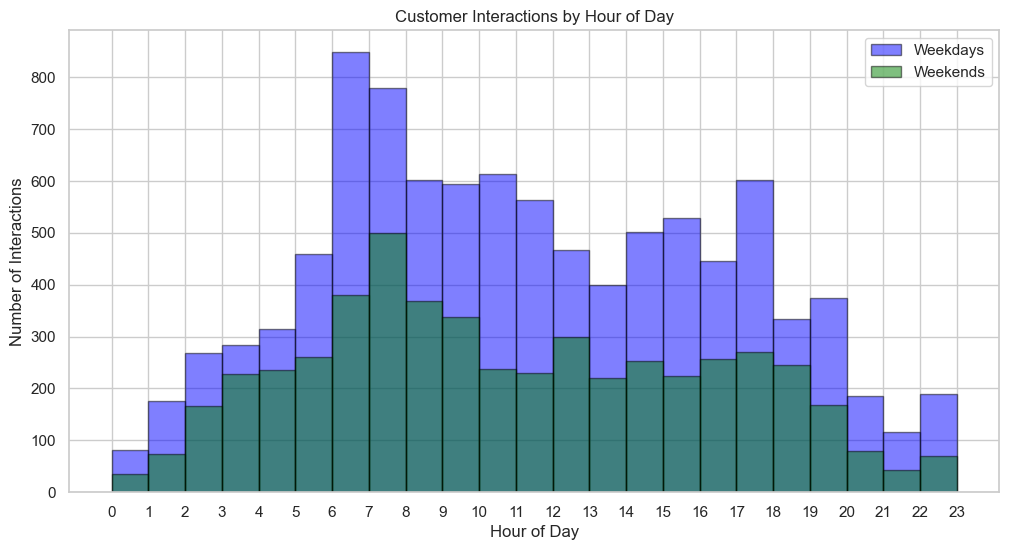

Weekday Peak Interaction Hours: 12 PM - 3 PM with a Conversion Rate of 0.00%
Weekend Peak Interaction Hours: 8 PM - 10 PM with a Conversion Rate of 0.00%


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("cleaned_ecommerce_data.csv")

# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Extract day of week and hour from the datetime
df['day_of_week'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour

# Define the cohorts
weekdays = [0, 1, 2, 3, 4]  # Monday to Friday
weekend = [5, 6]  # Saturday and Sunday

# Filtering the data for the two cohorts
weekday_data = df[df['day_of_week'].isin(weekdays)]
weekend_data = df[df['day_of_week'].isin(weekend)]

# Analyzing peak interaction hours for Weekday Shoppers
weekday_peak_hours = weekday_data[(weekday_data['hour'] >= 12) & (weekday_data['hour'] <= 15)]
weekday_purchases = weekday_peak_hours[weekday_peak_hours['event'] == 'purchase']
weekday_conversion_rate = (len(weekday_purchases) / len(weekday_peak_hours) if len(weekday_peak_hours) > 0 else 0) * 100

# Analyzing peak interaction hours for Weekend Shoppers
weekend_peak_hours = weekend_data[(weekend_data['hour'] >= 20) & (weekend_data['hour'] <= 22)]
weekend_purchases = weekend_peak_hours[weekend_peak_hours['event'] == 'purchase']
weekend_conversion_rate = (len(weekend_purchases) / len(weekend_peak_hours) if len(weekend_peak_hours) > 0 else 0) * 100

# Plotting the interaction hours for both cohorts
plt.figure(figsize=(12, 6))
plt.hist(weekday_data['hour'], bins=range(24), alpha=0.5, label='Weekdays', color='blue', edgecolor='black')
plt.hist(weekend_data['hour'], bins=range(24), alpha=0.5, label='Weekends', color='green', edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Interactions')
plt.title('Customer Interactions by Hour of Day')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

print(f"Weekday Peak Interaction Hours: 12 PM - 3 PM with a Conversion Rate of {weekday_conversion_rate:.2f}%")
print(f"Weekend Peak Interaction Hours: 8 PM - 10 PM with a Conversion Rate of {weekend_conversion_rate:.2f}%")


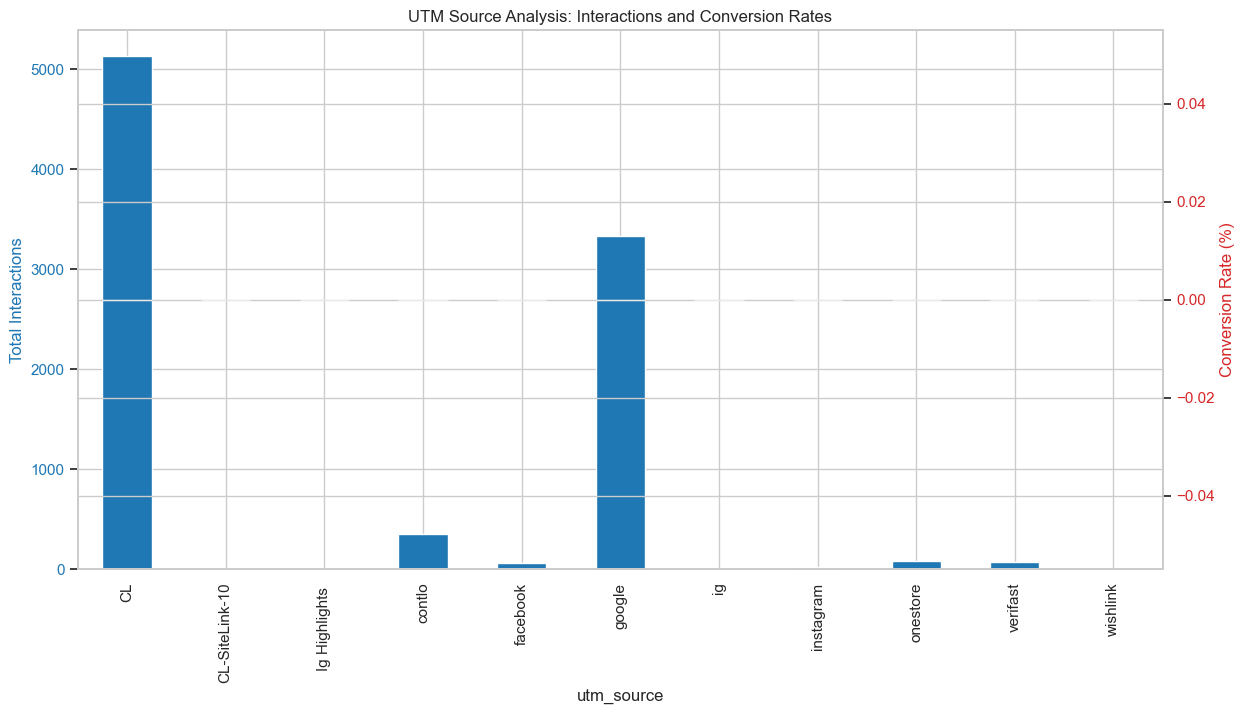

               total_interactions                 time                     
                            count                  min                  max
utm_source                                                                 
CL                           5131  2024-12-25 00:03:06  2024-12-31 23:11:15
CL-SiteLink-10                  1  2024-12-28 02:48:24  2024-12-28 02:48:24
Ig Highlights                   1  2024-12-29 10:39:10  2024-12-29 10:39:10
contlo                        355  2024-12-25 05:47:01  2024-12-31 22:18:24
facebook                       63  2024-12-25 03:19:56  2024-12-31 23:45:47
google                       3335  2024-12-25 00:01:46  2024-12-31 20:51:03
ig                              1  2024-12-29 04:13:55  2024-12-29 04:13:55
instagram                      20  2024-12-25 12:51:58  2024-12-31 10:31:45
onestore                       82  2024-12-25 07:30:13  2024-12-31 14:17:21
verifast                       74  2024-12-25 05:16:19  2024-12-31 22:40:42
wishlink    

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("cleaned_ecommerce_data.csv")

# Assuming the dataset has a 'utm_source' column, we analyze user interactions
if 'utm_source' in df.columns:
    # Filter data to include only interaction or conversion events
    interaction_data = df[df['event'].isin(['product_viewed', 'product_added_to_cart', 'checkout_started', 'checkout_completed'])]
    
    # Group by UTM source
    grouped_data = interaction_data.groupby('utm_source').agg({
        'event': 'count',
        'time': ['min', 'max']  # You might calculate session duration etc.
    }).rename(columns={'event': 'total_interactions'})
    
    # Calculate conversion rates
    conversion_data = interaction_data[interaction_data['event'] == 'checkout_completed'].groupby('utm_source').size()
    total_interactions = interaction_data.groupby('utm_source').size()
    conversion_rates = (conversion_data / total_interactions * 100).fillna(0)
    
    # Visualization of interactions and conversion rates
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    color = 'tab:blue'
    ax1.set_xlabel('UTM Source')
    ax1.set_ylabel('Total Interactions', color=color)
    total_interactions.plot(kind='bar', ax=ax1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Conversion Rate (%)', color=color)  # we already handled the x-label with ax1
    conversion_rates.plot(kind='bar', ax=ax2, color=color, alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('UTM Source Analysis: Interactions and Conversion Rates')
    plt.show()
    
    # Print summary statistics
    print(grouped_data)
    print("\nConversion Rates by UTM Source:")
    print(conversion_rates)
else:
    print("The dataset does not contain a 'utm_source' column. Please verify the dataset.")



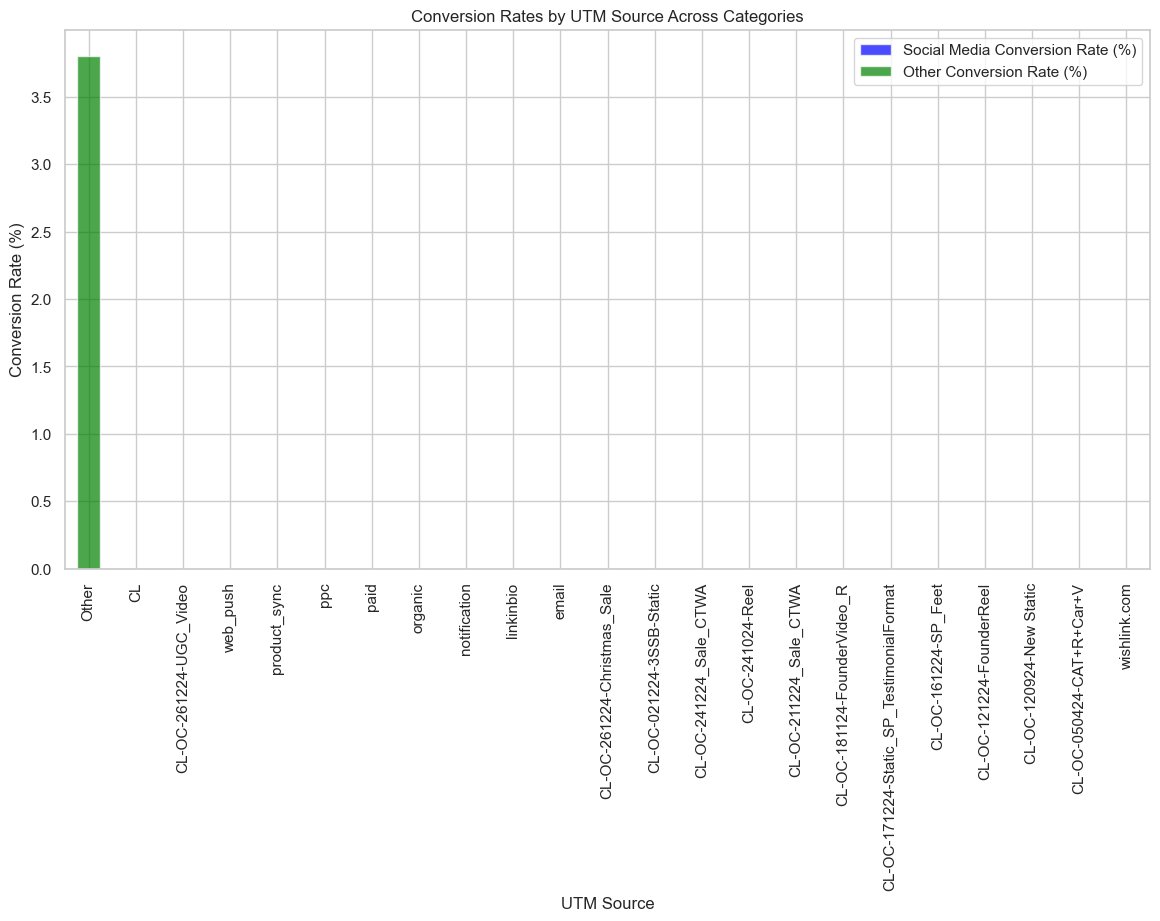

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("cleaned_ecommerce_data.csv")

# Define UTM column based on availability
utm_column = 'utm_medium' if 'utm_medium' in df.columns else 'utm_source'

# Convert all UTM entries to strings, handle NaNs
df[utm_column] = df[utm_column].fillna('Other').astype(str)

# Define known social media channels
social_media_channels = ['instagram', 'facebook', 'whatsapp', 'twitter', 'ig']

# Categorize each entry as Social Media or Other
df['category'] = df[utm_column].apply(lambda x: 'Social Media' if any(social in x.lower() for social in social_media_channels) else 'Other')

# Calculate conversion rates for each category
conversion_rates = {}
for category in ['Social Media', 'Other']:
    category_data = df[df['category'] == category]
    conversion_data = category_data[category_data['event'] == 'checkout_completed'].groupby(utm_column).size()
    total_interactions = category_data.groupby(utm_column).size()
    conversion_rates[category] = (conversion_data / total_interactions * 100).fillna(0)

# Plotting conversion rates for visual analysis
fig, ax = plt.subplots(figsize=(14, 7))
colors = {'Social Media': 'blue', 'Other': 'green'}

for category, rates in conversion_rates.items():
    rates.sort_values(ascending=False).plot(kind='bar', color=colors[category], ax=ax, label=f'{category} Conversion Rate (%)', alpha=0.7)

plt.title('Conversion Rates by UTM Source Across Categories')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('UTM Source')
plt.legend()
plt.show()



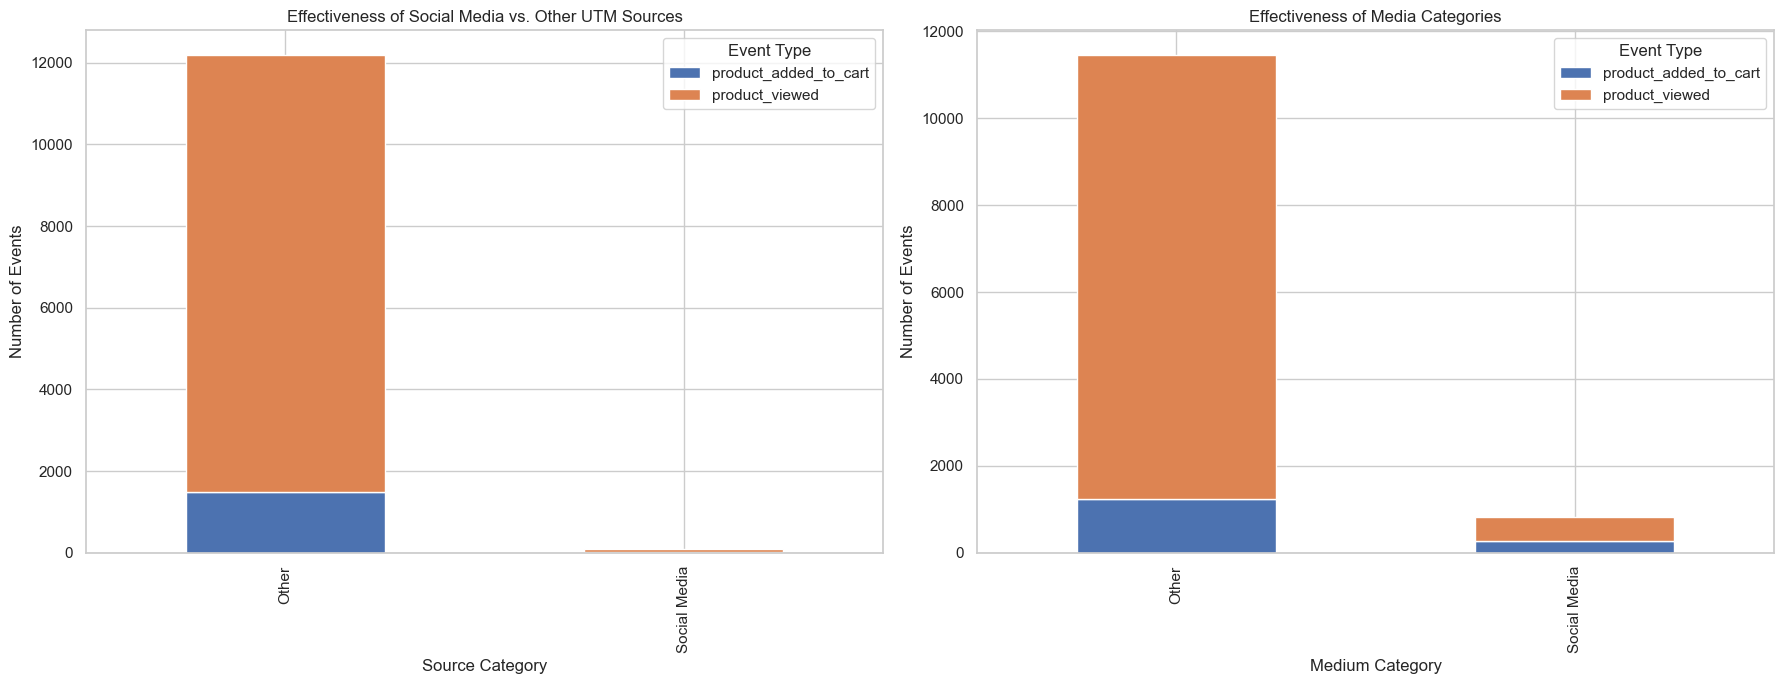

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("cleaned_ecommerce_data.csv")

# Define known social media channels
social_media_channels = ['instagram', 'facebook', 'twitter', 'whatsapp', 'ig', 'Ig Highlights']

# Ensure all entries in the UTM columns are strings
df['utm_source'] = df['utm_source'].astype(str)
df['utm_medium'] = df['utm_medium'].astype(str)

# Categorize each entry as Social Media or Other based on the UTM source
df['source_category'] = df['utm_source'].apply(lambda x: 'Social Media' if any(social.lower() in x.lower() for social in social_media_channels) else 'Other')
df['medium_category'] = df['utm_medium'].apply(lambda x: 'Social Media' if any(social.lower() in x.lower() for social in social_media_channels) else 'Other')

# Filter the dataframe for the focused events: 'product_viewed' and 'product_added_to_cart'
event_focus = ['product_viewed', 'product_added_to_cart']
df_focused = df[df['event'].isin(event_focus)]

# Group by the new category and calculate occurrences of each event
source_counts = df_focused.groupby(['source_category', 'event']).size().unstack().fillna(0)
medium_counts = df_focused.groupby(['medium_category', 'event']).size().unstack().fillna(0)

# Plotting the results for visual analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
source_counts.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Effectiveness of Social Media vs. Other UTM Sources')
ax1.set_xlabel('Source Category')
ax1.set_ylabel('Number of Events')
ax1.legend(title='Event Type')

medium_counts.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Effectiveness of Media Categories')
ax2.set_xlabel('Medium Category')
ax2.set_ylabel('Number of Events')
ax2.legend(title='Event Type')

plt.tight_layout()
plt.show()


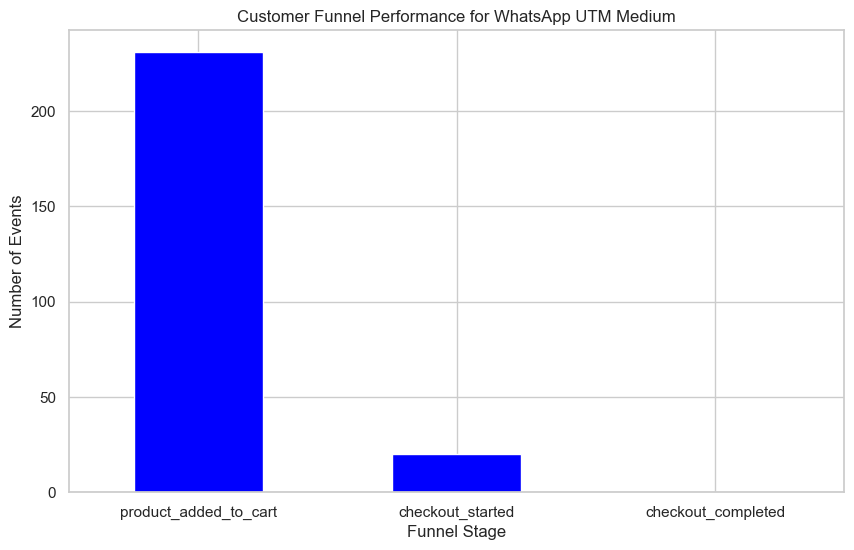

event
product_added_to_cart    231
checkout_started          20
checkout_completed         0
Name: count, dtype: int64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("cleaned_ecommerce_data.csv")

# Ensure all entries in the UTM columns are strings, explicitly handling NaNs
df['utm_source'] = df['utm_source'].astype(str).fillna('unknown')
df['utm_medium'] = df['utm_medium'].astype(str).fillna('unknown')

# Filter for WhatsApp medium
df_whatsapp = df[df['utm_medium'].str.lower().str.contains('whatsapp')]

# Define the reduced funnel stages
funnel_stages = ['product_added_to_cart', 'checkout_started', 'checkout_completed']

# Filter the dataframe for the reduced funnel stages
df_whatsapp_funnel = df_whatsapp[df_whatsapp['event'].isin(funnel_stages)]

# Count occurrences of each event
whatsapp_funnel_counts = df_whatsapp_funnel['event'].value_counts().reindex(funnel_stages, fill_value=0)

# Plotting the results for visual analysis
plt.figure(figsize=(10, 6))
whatsapp_funnel_counts.plot(kind='bar', color='blue')
plt.title('Customer Funnel Performance for WhatsApp UTM Medium')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Events')
plt.xticks(rotation=0)  # Keep the labels horizontal for readability
plt.show()

# Print the counts for detailed analysis
print(whatsapp_funnel_counts)


In [10]:
import pandas as pd

# Load the uploaded file to examine its structure and find potential issues
file_path = '//Users/prakharsingh/Downloads/cleaned_ecommerce_data.csv'
cohort_analysis = pd.read_csv(file_path)

# Display the first few rows and column names to identify any issues
cohort_analysis.head(), cohort_analysis.columns

(            event                 time                           customer_id  \
 0  product_viewed  2024-12-31 04:01:56  9dc992e7-619f-42b2-8847-2661f18171c5   
 1  product_viewed  2024-12-31 04:11:34  0b307d43-5d30-4ff2-8aa8-98a8e50c921d   
 2  product_viewed  2024-12-31 06:32:26  d37578dd-7de0-4870-b128-3cce8fc9ac5e   
 3  product_viewed  2024-12-31 08:51:02  816e25d5-fbbe-4c01-823a-b57007d29241   
 4  product_viewed  2024-12-31 09:04:32  a21aba27-0a9f-43df-9148-d9dac3af4741   
 
                                         referrer_url  \
 0  https://client_name/collections/psoriasis-skin...   
 1  https://client_name/collections/psoriasis-skin...   
 2  https://client_name/collections/psoriasis-skin...   
 3  https://client_name/collections/psoriasis-skin...   
 4  https://client_name/products/skin-softening-af...   
 
                                        product_title utm_source  \
 0    Restorative Shampoo for Anti Dandruff Treatment         CL   
 1    Restorative Shampoo for An

In [11]:
cohort_analysis['time'] = pd.to_datetime(cohort_analysis['time'])

# Derive the 'Cohort' column from the 'time' column
cohort_analysis['Cohort'] = cohort_analysis['time'].dt.strftime('%Y-%m')

# Filter data for the December 2024 cohort
dec_cohort = cohort_analysis[cohort_analysis['Cohort'] == '2024-12']

# Display the first few rows of the filtered cohort data for review
dec_cohort.head()

,event,time,customer_id,referrer_url,product_title,utm_source,utm_medium,utm_campaign,utm_content,utm_id,Cohort
0,product_viewed,2024-12-31 04:01:56,9dc992e7-619f-42b2-8847-2661f18171c5,https://client_name/collections/psoriasis-skin...,Restorative Shampoo for Anti Dandruff Treatment,CL,CL-OC-211224_Sale_CTWA,Adv+ - LP,Restorative Shampoo Sale ctwa - Copy,1,2024-12
1,product_viewed,2024-12-31 04:11:34,0b307d43-5d30-4ff2-8aa8-98a8e50c921d,https://client_name/collections/psoriasis-skin...,Restorative Shampoo for Anti Dandruff Treatment,CL,CL-OC-211224_Sale_CTWA,Adv+ - LP,Restorative Shampoo Sale ctwa - Copy,1,2024-12
2,product_viewed,2024-12-31 06:32:26,d37578dd-7de0-4870-b128-3cce8fc9ac5e,https://client_name/collections/psoriasis-skin...,Small Patches - Eczema and Psoriasis Care Bundle,CL,CL-OC-241024-Reel,Advt+,Small Patches,120212772383610086,2024-12
3,product_viewed,2024-12-31 08:51:02,816e25d5-fbbe-4c01-823a-b57007d29241,https://client_name/collections/psoriasis-skin...,"Ultra Healing Cream (for Dry/ Cracked skin, Ps...",CL,CL-OC-261224-UGC_Video,Adv+,Ultra Healing Cream_ Rachit,NaN,2024-12
4,product_viewed,2024-12-31 09:04:32,a21aba27-0a9f-43df-9148-d9dac3af4741,https://client_name/products/skin-softening-af...,"Skin Softening Body Oil (for Dry Skin, Eczema ...",google,product_sync,sag_organic,sag_organic,NaN,2024-12


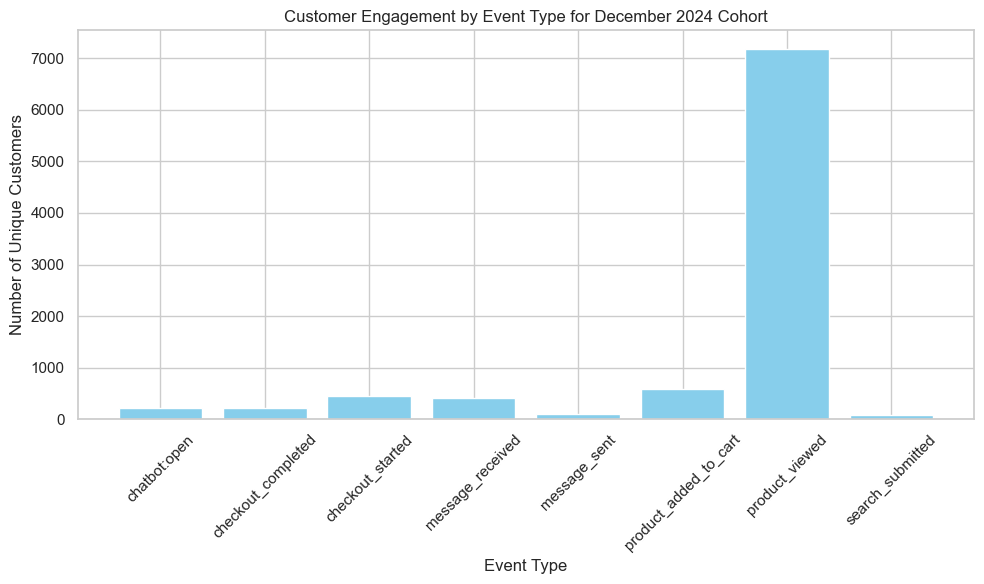

'Conversion Rate from Product Viewed to Checkout Started: 6.31%'

In [12]:
import matplotlib.pyplot as plt

# Group by 'event' and calculate the number of unique customers for each event
unique_customers = dec_cohort.groupby('event')['customer_id'].nunique().reset_index()
unique_customers.columns = ['event', 'Unique_Customers']

# Plotting the number of unique customers per event type
plt.figure(figsize=(10, 6))
plt.bar(unique_customers['event'], unique_customers['Unique_Customers'], color='skyblue')
plt.xlabel('Event Type')
plt.ylabel('Number of Unique Customers')
plt.title('Customer Engagement by Event Type for December 2024 Cohort')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Extract data for conversion rate calculation
viewed = unique_customers.loc[unique_customers['event'] == 'product_viewed', 'Unique_Customers'].values[0]
checkout_started = unique_customers.loc[unique_customers['event'] == 'checkout_started', 'Unique_Customers'].values[0] if 'checkout_started' in unique_customers['event'].values else 0

# Calculate and display the conversion rate
conversion_rate = (checkout_started / viewed) * 100 if viewed > 0 else 0
conversion_rate_text = f"Conversion Rate from Product Viewed to Checkout Started: {conversion_rate:.2f}%"
conversion_rate_text


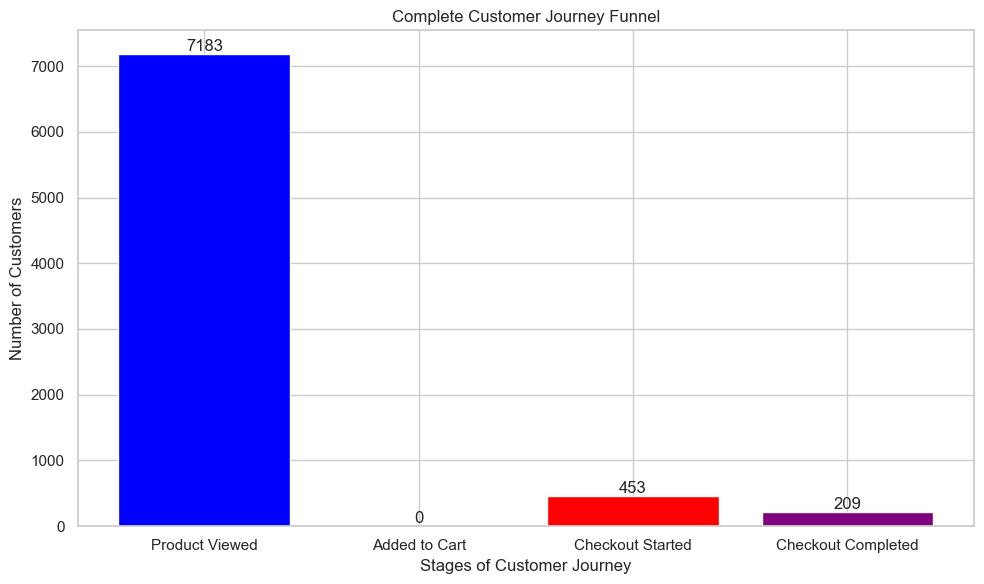

('Checkout Abandonment Rate: 53.86%',
 'Number of Chatbot Interactions During Checkout Process: 0')

In [13]:
# Ensure column names align with the dataset structure
checkout_completed_count = cohort_analysis[cohort_analysis['event'] == 'checkout_completed']['customer_id'].nunique()

# Example counts for other stages (replace with actual calculations if available)
viewed_count = cohort_analysis[cohort_analysis['event'] == 'product_viewed']['customer_id'].nunique()
added_to_cart_count = cohort_analysis[cohort_analysis['event'] == 'added_to_cart']['customer_id'].nunique()
checkout_started_count = cohort_analysis[cohort_analysis['event'] == 'checkout_started']['customer_id'].nunique()

# Stages and their respective counts
stages = ['Product Viewed', 'Added to Cart', 'Checkout Started', 'Checkout Completed']
counts = [viewed_count, added_to_cart_count, checkout_started_count, checkout_completed_count]

# Calculate abandonment rate between 'Checkout Started' and 'Checkout Completed'
checkout_abandonment_rate = 1 - (checkout_completed_count / checkout_started_count) if checkout_started_count > 0 else 0

# Plotting the funnel chart
plt.figure(figsize=(10, 6))
plt.bar(stages, counts, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Stages of Customer Journey')
plt.ylabel('Number of Customers')
plt.title('Complete Customer Journey Funnel')
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), horizontalalignment='center')
plt.tight_layout()
plt.show()

# Display the abandonment rate
abandonment_rate_text = f"Checkout Abandonment Rate: {checkout_abandonment_rate:.2%}"

# Analyze chatbot interactions relative to other key events
chatbot_times = cohort_analysis[cohort_analysis['event'] == 'chatbot:open']['time']
added_to_cart_times = cohort_analysis[cohort_analysis['event'] == 'added_to_cart']['time']
checkout_start_times = cohort_analysis[cohort_analysis['event'] == 'checkout_started']['time']

# Check chatbot interactions during the checkout process
chatbot_during_checkout = chatbot_times[(chatbot_times > added_to_cart_times.min()) & (chatbot_times < checkout_start_times.max())]

# Display chatbot analysis result
chatbot_analysis_text = f"Number of Chatbot Interactions During Checkout Process: {len(chatbot_during_checkout)}"

abandonment_rate_text, chatbot_analysis_text


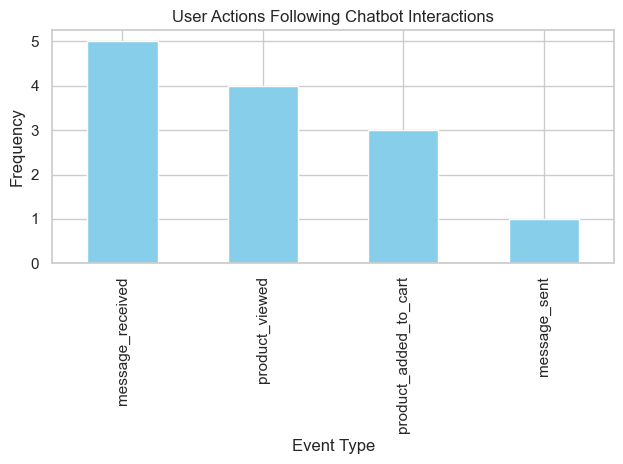

In [14]:
# Extract rows where the event corresponds to chatbot interactions
chatbot_interactions = df[df['event'] == 'chatbot:open']
# Filter actions that occurred after the last recorded chatbot interaction
subsequent_actions = df[df['time'] > chatbot_interactions['time'].max()]
# Filter actions that occurred after the last recorded chatbot interaction
subsequent_actions = df[df['time'] > chatbot_interactions['time'].max()]
# Count the frequency of events and plot them as a bar chart
subsequent_actions['event'].value_counts().plot(kind='bar', color='skyblue')
plt.title('User Actions Following Chatbot Interactions')  # Add chart title
plt.xlabel('Event Type')  # Label x-axis
plt.ylabel('Frequency')  # Label y-axis
plt.tight_layout()  # Adjust layout for better visualization
plt.show()
